SVHN데이터 셋을 이용한 Classification 인공신경망 

In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D,Dropout,BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import initializers
from scipy import io
import numpy as np
import matplotlib.pyplot as plt
#싸이킷 런에서 컨퓨전 매트릭스 계산
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Dataset 전처리

In [2]:
#data 로딩
train_data=io.loadmat(r'C:\Users\USER\OneDrive - Chonnam National University\바탕 화면\archive (1)\train_32x32.mat')
test_data=io.loadmat(r'C:\Users\USER\OneDrive - Chonnam National University\바탕 화면\archive (1)\test_32x32.mat')
extra_data=io.loadmat(r'C:\Users\USER\OneDrive - Chonnam National University\바탕 화면\archive (1)\extra_32x32.mat')

In [17]:
tf.__version__

'2.10.0'

In [3]:
#  데이터RGB 정규화
train_x=train_data['X']
train_x=train_x[...,:50000]/255.

train_y=train_data['y']
train_y=train_y[:50000]

extra_x=extra_data['X']
extra_x=extra_x[...,:5000]/255.

extra_y=extra_data['y']
extra_y=extra_y[:5000]

# train 할 수 있게 축 변경
train_x = np.moveaxis(train_x, -1, 0)
extra_x = np.moveaxis(extra_x, -1, 0)
train_x.shape


# 굳이 원핫 인코딩 안했는데 해야되나? 안하고 int label 그대로 가져가도 됨 다만 loss function 설정을 sparse cross entropy로 할 것
train_y = tf.keras.utils.to_categorical(np.array(train_y))
extra_y = tf.keras.utils.to_categorical(np.array(extra_y))


train_x,val_x,train_y,val_y = train_test_split(train_x, train_y,test_size=0.1, random_state=22)

MemoryError: Unable to allocate 1.14 GiB for an array with shape (32, 32, 3, 50000) and data type float64

In [19]:
train_x.shape

(45000, 32, 32, 3)

Model 정의

In [ ]:

def get_model():
    model=Sequential([
        Conv2D(32, (3, 3), padding='same', 
                            activation='relu',
                            input_shape=(32, 32, 3)),
        BatchNormalization(),
        Conv2D(32, (3, 3), padding='same', 
                            activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        
        Conv2D(64, (3, 3), padding='same', 
                            activation='relu'),
        BatchNormalization(),
        Conv2D(64, (3, 3), padding='same',
                            activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        
        Conv2D(128, (3, 3), padding='same', 
                            activation='relu'),
        BatchNormalization(),
        Conv2D(128, (3, 3), padding='same',
                            activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.4),    
        Dense(11,  activation='softmax')
])
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])
    return model

In [9]:
train_x.shape

(65931, 32, 32, 3)

In [23]:
def get_model1():
    model=Sequential([
        Conv2D(filters=16,input_shape=(32,32,3),kernel_size=(3,3),activation='relu',name='conv_1'),
        Conv2D(filters=8,kernel_initializer=tf.keras.initializers.HeUniform,kernel_size=(3,3),activation='relu',name='conv_2'),
        MaxPooling2D(pool_size=(4,4),name='pool_1'),
        BatchNormalization(),
        Conv2D(filters=16,kernel_size=(3,3),activation='relu',name='conv_3'),
        MaxPooling2D(pool_size=(4,4),name='pool_2'),
        Flatten(name='Flatten'),
        Dense(units=32,activation='relu',name='dense_1'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(units=11,activation='softmax',name='dense_2')
    ])

    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

    return model

Callback 함수 생성

In [ ]:

checkpoint_path='model_checkpoints/checkpoint'
checkpoint=ModelCheckpoint(filepath=checkpoint_path,frequency='epoch',save_weights_only=False,verbose=1,save_best_only=True)

Model 학습

In [ ]:
model=get_model()
history=model.fit(x=train_x,y=train_y,epochs=100,batch_size=32,validation_data=(val_x,val_y),verbose=1,callbacks=[checkpoint])

Train dataset & Valid dataset의 acc 시각화

In [ ]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.legend()
plt.title('Epochs vs. Training and Validation Accuracy')
    
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Epochs vs. Training and Validation Loss')

plt.show()

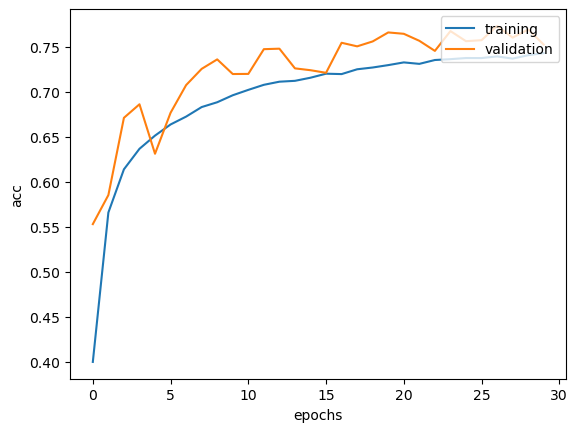

In [17]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(['training','validation'],loc='upper right')
plt.show()

Extra dataset prediction을 통한 검증

In [184]:
test_loss,test_acc=model.evaluate(x=extra_x,y=extra_y,verbose=1)
print("Loss of extra dataset: {0:.3f},  Acc of extra dataset: {1:.3f}".format(test_loss,test_acc))

469/469 [==============================] - 1s 3ms/step - loss: 0.5017 - acc: 0.8425
Loss of extra dataset: 0.502,  Acc of extra dataset: 0.842


In [ ]:
prediction=model.predict(extra_x[...,:10])

ans=extra_y

plt.figure(figsize=(10,10))


for i in range(10):
    print("예측값: {0}    실제값: {1}".format(np.argmax(prediction[i]),np.argmax(ans[i])))
    plt.subplot(1,10,i+1),plt.imshow(extra_x[i]),plt.axis('off')  

plt.show()